In [1]:
%matplotlib widget
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py 
# from BasisConvolution.util.datautils import parseFile
import os

from state import DataConfiguration
from util import processFolder, getDataLoader
from newFormatLoader import loadFrame_newFormat_v2, convertNewFormatToWCSPH, loadNewFormatState
from loader import loadState
from loader import loadBatch
from neighborhood import neighborSearch, filterNeighborhoodByKind

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm
from state import WeaklyCompressibleSPHState, CompressibleSPHState, RigidBodyState
from batch import mergeBatch, mergeTrajectoryStates
from augment import augmentDomain, rotateState, buildRotationMatrix
from util import kernelNameToKernel
from augment import loadAugmentedBatch
from sphMath.plotting import visualizeParticles, updatePlot
import matplotlib.pyplot as plt



In [2]:
# folder = '/mnt/data/homeBak/dev/SFBC/datasets/test_case_II/train/'
# folder = '/mnt/data/homeBak/dev/SFBC/datasets/test_case_III/train/'
# folder = '/mnt/data/dsets/datasetB/export/'
# folder = '/mnt/data/wcsph_datasets/wcsph_flows_free_slip/testing/noObstacle/'
# folder = '/home/winchenbach/dev/datasets/wcsph_flows_no_slip/testing/noObstacle/'
# folder = '/home/winchenbach/dev/datasets/testcase_II/'
folder = './data'
# folder = '/home/winchenbach/dev/datasets/diffSPH_WCSPH/'

# folder = '/home/winchenbach/dev/SFBC/datasets/test_case_II/train/'

In [3]:
configuration = DataConfiguration(
    frameDistance=1,
    frameSpacing=1,
    maxRollout=1,
    historyLength=1,
    skipInitialFrames=0,
    cutoff=0
)

processed = processFolder(folder, configuration)

for file in processed:
    print(f'File: {file["fileName"]}, FrameCount: {len(file["frames"])}, Samples: {len(file["samples"])}, Style: {file["style"]}, Number of samples: {len(processed[0]["samples"])}, first sample: {processed[0]["samples"][0]}, last sample: {processed[0]["samples"][-1]}')


Found 1 simulation files in ./data, [['06_periodicRandomFlow_4_2_0.5_2_True_perlin_45906734_without.h5']]
File: ./data/06_periodicRandomFlow_4_2_0.5_2_True_perlin_45906734_without.h5, FrameCount: 4095, Samples: 4095, Style: diffSPH, Number of samples: 4095, first sample: 000001, last sample: 004095


In [4]:
dataset, datasetLoader = getDataLoader(processed, 4, shuffle = True)
datasetIter = iter(datasetLoader)

nextData = next(datasetIter)
print(f'Next data: {nextData}')

# nextData = [4012, 19, 2858, 2215]

Next data: [1318, 193, 2828, 2593]


In [5]:
priorStates, currentState, trajectoryStates, domains, rotMats, configs, neighborhoods = loadAugmentedBatch(
    dataset, nextData, configuration, device = 'cuda', dtype = torch.float32,
    augmentAngle = True,
)

In [6]:
fig, axis = plt.subplots(1, len(nextData), figsize=(len(nextData) * 4, 5), squeeze = False)
# filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')

plots = []
axes = axis.flatten()
for b in range(len(domains)):
    plot = visualizeParticles(fig, axes[b],
                              particles = currentState,
                              domain = domains[b],
                              quantity = currentState.velocities,
                              which = 'both',
                              mapping = 'L2',
                              cmap = 'RdBu_r',
                              visualizeBoth=True,
                              kernel = kernelNameToKernel(configs[b]['kernel']),
                              plotDomain = True,
                              gridVisualization=False, markerSize=2,
                              batch = b)
    axes[b].set_title(f'Batch {b} {nextData[b]} - t={currentState.time[b]:.2f}s,')
    plots.append(plot)

fig.tight_layout()

In [7]:
from sphMath.operations import sph_op
from sphMath.kernels import getSPHKernelv2
from util import buildRotationMatrix
from neighborhood import coo_to_csr

def evalDensity(state, neighborhood, domains, config):
    quantity = torch.ones_like(state.densities)

    return sph_op(
        state, state, domains, getSPHKernelv2('Wendland2'), neighborhood, quantity = state.velocities, supportScheme='gather', operation = 'density'
    )

filteredNeighborhood = filterNeighborhoodByKind(currentState, neighborhoods, 'noghost')
filtered_csr = coo_to_csr(filteredNeighborhood)

rho = evalDensity(currentState, filteredNeighborhood, domains, configs[0])

for b in range(len(domains)):
    updatePlot(plots[b], particles = currentState, quantity = filtered_csr.rowEntries, mapping = 'L2', cmap = 'viridis')
    # updatePlot(plots[b], particles = currentState, quantity = rho, mapping = '.x', cmap = 'RdBu_r')

In [8]:
from augment import buildRotationMatrix, augmentDomain, rotateState, getRandomRotationMatrix
from neighborhood import DomainDescription, AugmentedDomainDescription

In [9]:
from neighborhood import evalDistanceTensor
rij, xij, hi, hj = evalDistanceTensor(neighborhoods)

print(rij.shape, neighborhoods.row.shape)
print(xij.shape, neighborhoods.col.shape)

torch.Size([823448]) torch.Size([823448])
torch.Size([823448, 2]) torch.Size([823448])


In [10]:
from BasisConvolution.convLayerv3 import BasisConvLayer

In [11]:
testLayer = BasisConvLayer(
    inputFeatures = 1,
    outputFeatures = 1,
    dim = domains[0].dim,

    basisTerms = 4,
    basisFunction = 'linear',
    basisPeriodicity = False,

    biasActive= False,
    cutlassBatchSize= 16,

    mode = 'conv'
).to('cuda', dtype = torch.float32)

optimizer = torch.optim.Adam(testLayer.parameters(), lr=1e-3)

In [12]:
priorStates, currentState, trajectoryStates, domains, rotMats, configs, neighborhoods = loadAugmentedBatch(
    dataset, [0, 1, 2, 3], configuration, device = 'cuda', dtype = torch.float32,
    augmentAngle = False,
)

In [13]:
inputFeatures = torch.ones_like(currentState.densities).unsqueeze(-1)

filteredNeighborhood = filterNeighborhoodByKind(currentState, neighborhoods, 'noghost')
edge_index = torch.stack([filteredNeighborhood.row, filteredNeighborhood.col])
# print(edge_index.shape)

rij, xij_, h_i, h_j = evalDistanceTensor(filteredNeighborhood)
edge_attr = xij_ / h_i[:, None] 

out, _ = testLayer(
    x = [inputFeatures, inputFeatures],
    edge_index = edge_index,
    edge_attr = edge_attr,
    batches = 1,
)
rho = evalDensity(currentState, filteredNeighborhood, domains, configs[0]) / configs[0]['fluid']['rho0']

print(f'Output shape: {out.shape}'
      f', Input shape: {inputFeatures.shape}, Edge index shape: {edge_index.shape}, Edge attr shape: {edge_attr.shape}')

Output shape: torch.Size([16384, 1]), Input shape: torch.Size([16384, 1]), Edge index shape: torch.Size([2, 771174]), Edge attr shape: torch.Size([771174, 2])


In [14]:
fig, axis = plt.subplots(1, len(nextData), figsize=(len(nextData) * 4, 5), squeeze = False)
# filteredNeighborhood = filterNeighborhoodByKind(currentStates[0], neighborhoods[0], 'noghost')

plots = []
axes = axis.flatten()
for b in range(len(domains)):
    plot = visualizeParticles(fig, axes[b],
                              particles = currentState,
                              domain = domains[b],
                              quantity = rho,
                              which = 'both',
                              mapping = 'L2',
                              cmap = 'RdBu_r',
                              visualizeBoth=True,
                              kernel = kernelNameToKernel(configs[b]['kernel']),
                              plotDomain = True,
                              gridVisualization=False, markerSize=2,
                              batch = b)
    axes[b].set_title(f'Batch {b} {nextData[b]} - t={currentState.time[b]:.2f}s,')
    plots.append(plot)

fig.tight_layout()

In [20]:
testLayer = BasisConvLayer(
    inputFeatures = 1,
    outputFeatures = 1,
    dim = domains[0].dim,

    basisTerms = 5,
    basisFunction = 'ffourier even',
    basisPeriodicity = False,

    biasActive= False,
    cutlassBatchSize= 16,

    mode = 'conv', edgeSkip = 'ij'
).to('cuda', dtype = torch.float32)

optimizer = torch.optim.Adam(testLayer.parameters(), lr=1e-2)

losses = []

for i in (tq := tqdm(range(2000))):
    try:
        batch = next(datasetIter)
    except StopIteration:
        datasetIter = iter(datasetLoader)
        batch = next(datasetIter)
    # nextData = [1024]
    # nextData = [batch[0], batch[0] + 1]  # Use the first batch item for testing
    nextData = batch

    priorStates, currentState, trajectoryStates, domains, rotMats, configs, neighborhoods = loadAugmentedBatch(
        dataset, nextData, configuration, device = 'cuda', dtype = torch.float32,
        augmentAngle = True,
    )
    # print(f'Batch: {batch}, Time: {currentState.time}')
    # priorStates, currentStates, trajectoryStates, domains, configs = loadBatch(dataset, batch, configuration, device = 'cuda', dtype = torch.float32)
    # neighborhoods = []
    # for state, domain, config in zip(currentStates, domains, configs):
    #     neighborhood = neighborSearch(state, domain, config)
    #     neighborhoods.append(neighborhood)

    inputFeatures = torch.ones_like(currentState.densities).unsqueeze(-1)
    # inputFeatures = currentStates[0].masses.unsqueeze(-1)

    filteredNeighborhood = filterNeighborhoodByKind(currentState, neighborhoods, 'noghost')
    edge_index = torch.stack([filteredNeighborhood.row, filteredNeighborhood.col])
    # print(edge_index.shape)

    rij, xij_, h_i, h_j = evalDistanceTensor(filteredNeighborhood)
    edge_attr = xij_ / h_i[:,None]



    optimizer.zero_grad()
    out, _ = testLayer(
        x = [inputFeatures, inputFeatures],
        edge_index = edge_index,
        edge_attr = edge_attr,
        batches = 1,
    )

    # print(f'Output shape: {out.shape}')
    rho = evalDensity(currentState, filteredNeighborhood, domains, configs[0]) / configs[0]['fluid']['rho0']
    gt = rho
    gt = gt.reshape(-1, 1)

    error = gt - out
    error = error[currentState.kinds == 0]

    loss = torch.sum(error ** 2)
    loss.backward()

    # print(f'Training Setp for Batch {batch}')
    # print(f'Density: {torch.mean(gt):.4f} +- {torch.std(gt):.4f}, Output: {torch.mean(out):.4f} +- {torch.std(out):.4f}, {currentState.time}')
    # print(f'Prediction: {torch.mean(out):.4f} +- {torch.std(out):.4f}, Ground Truth: {torch.mean(gt):.4f} +- {torch.std(gt):.4f}')
    # print(f'Distances: {torch.mean(xij_):.4f} +- {torch.std(xij_):.4f}, {torch.mean(h_i):.4f} +- {torch.std(h_i):.4f}, {torch.mean(h_j):.4f} +- {torch.std(h_j):.4f}')
    # print(f'Edge index: {edge_index.shape}, Edge attr: {edge_attr.shape}')


    optimizer.step()
    tq.set_description(f'Loss: {loss.item():.4f} [{nextData}], Density: {torch.mean(gt):.4f} +- {torch.std(gt):.4f}, Output: {torch.mean(out):.4f} +- {torch.std(out):.4f}, {currentState.time}')
    losses.append(loss.item())
    # print('Loss: ', loss)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [21]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5), squeeze = False)

axis[0,0].plot(losses)
axis[0,0].set_title('Loss over iterations')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')

axis[0,0].grid(True)
axis[0,0].set_yscale('log')
fig.tight_layout()

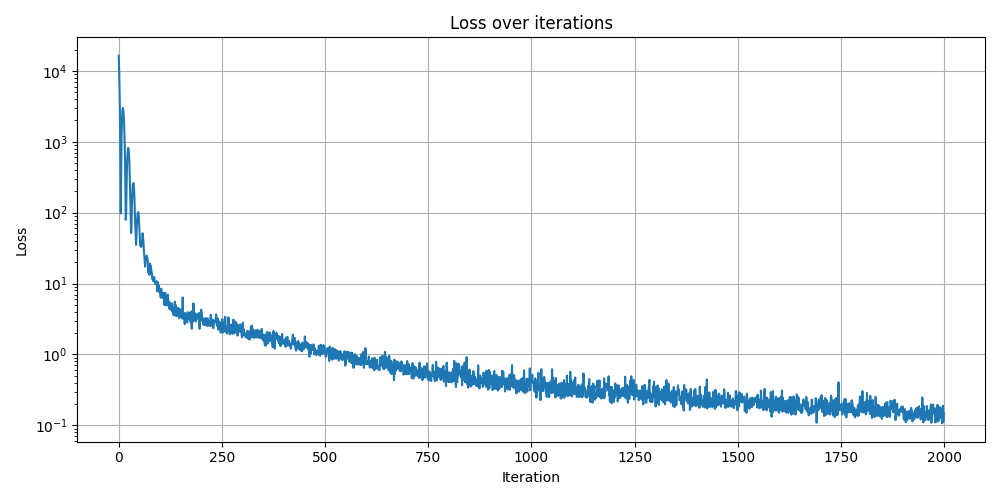

In [17]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5), squeeze = False)

axis[0,0].plot(losses)
axis[0,0].set_title('Loss over iterations')
axis[0,0].set_xlabel('Iteration')
axis[0,0].set_ylabel('Loss')

axis[0,0].grid(True)
axis[0,0].set_yscale('log')
fig.tight_layout()

In [18]:
print(neighborhoods.row.max(), neighborhoods.col.max())
print(edge_index[0].max(), edge_index[1].max())
print(edge_attr.shape, edge_index.shape, neighborhoods.row.shape, neighborhoods.col.shape)

tensor(16383, device='cuda:0') tensor(16383, device='cuda:0')
tensor(16383, device='cuda:0') tensor(16383, device='cuda:0')
torch.Size([823394, 2]) torch.Size([2, 823394]) torch.Size([823394]) torch.Size([823394])


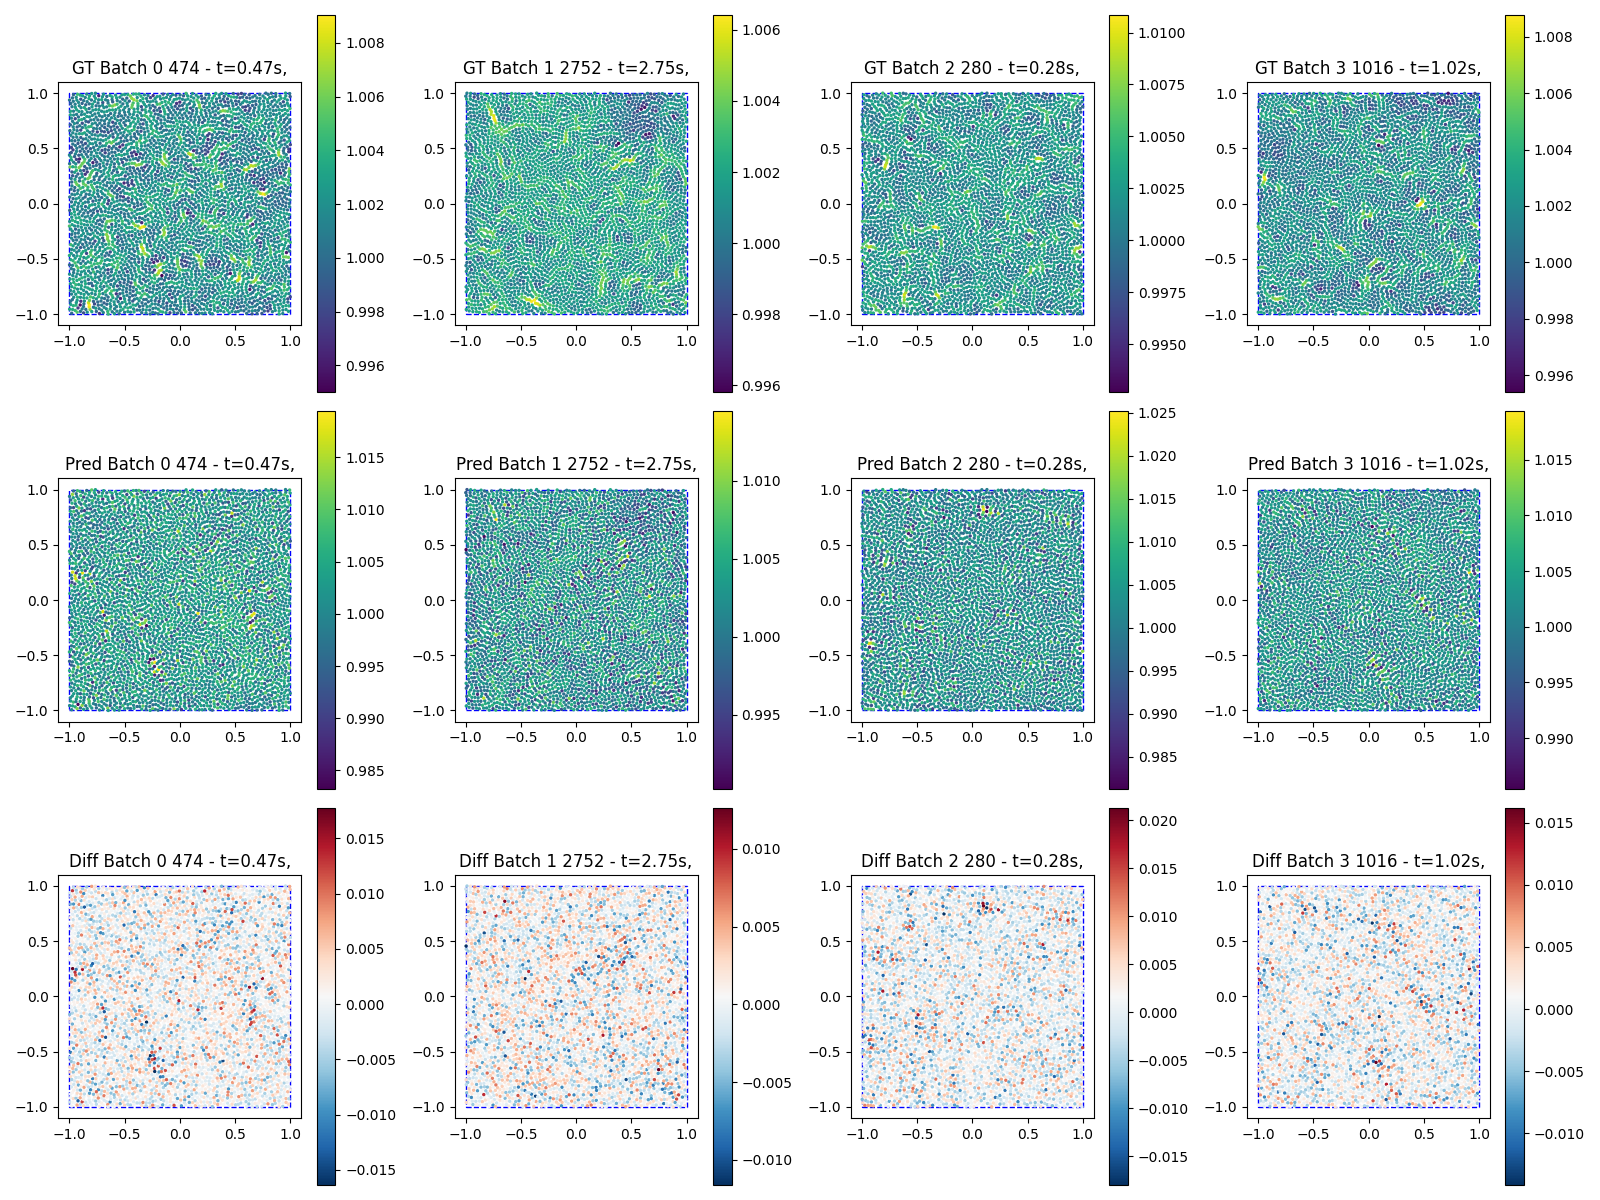

In [22]:
from sphMath.plotting import visualizeParticles
import matplotlib.pyplot as plt


fig, axis = plt.subplots(3, len(domains), figsize=(len(domains)*4, 12), squeeze = False)

plots = []
axes = axis.flatten()
for b in range(len(domains)):
    plot = visualizeParticles(fig, axis[0,b],
                              particles = currentState,
                              domain = domains[b],
                              quantity = gt[:,0],
                              which = 'both',
                              mapping = 'L2',
                              cmap = 'viridis',
                              visualizeBoth=True,
                              kernel = kernelNameToKernel(configs[b]['kernel']),
                              plotDomain = True,
                              gridVisualization=False, markerSize=2,
                              batch = b)
    axis[0,b].set_title(f'GT Batch {b} {nextData[b]} - t={currentState.time[b]:.2f}s,')
    plots.append(plot)

    plot2 = visualizeParticles(fig, axis[1,b],
                              particles = currentState,
                              domain = domains[b],
                              quantity = out[:,0],
                              which = 'both',
                              mapping = 'L2',
                              cmap = 'viridis',
                              visualizeBoth=True,
                              kernel = kernelNameToKernel(configs[b]['kernel']),
                              plotDomain = True,
                              gridVisualization=False, markerSize=2,
                              batch = b)
    axis[1,b].set_title(f'Pred Batch {b} {nextData[b]} - t={currentState.time[b]:.2f}s,')
    plots.append(plot)

    plot3 = visualizeParticles(fig, axis[2,b],
                              particles = currentState,
                              domain = domains[b],
                              quantity = out[:,0] - gt[:,0],
                              which = 'both',
                              mapping = 'L2',
                              cmap = 'RdBu_r',
                              visualizeBoth=True,
                              kernel = kernelNameToKernel(configs[b]['kernel']),
                              plotDomain = True,
                              gridVisualization=False, markerSize=2,
                              batch = b)
    axis[2,b].set_title(f'Diff Batch {b} {nextData[b]} - t={currentState.time[b]:.2f}s,')
    plots.append(plot3)

fig.tight_layout()

fig.tight_layout()

In [23]:
xx = torch.linspace(-1, 1, 101).to('cuda', dtype = torch.float32)
yy = torch.linspace(-1, 1, 101).to('cuda', dtype = torch.float32)
X, Y = torch.meshgrid(xx, yy, indexing='ij')
edge_attr = torch.stack([X.flatten(), Y.flatten()], dim=-1).to('cuda', dtype = torch.float32)

edge_index = torch.stack([torch.arange(X.numel()).to('cuda'), torch.zeros_like(X).flatten().to(torch.int64)])
inputs = torch.ones_like(X).flatten().unsqueeze(-1).to('cuda', dtype = torch.float32)


print(edge_index.shape, edge_attr.shape, inputs.shape)

out, _ = testLayer(
    x = [inputs, inputs],
    edge_index = edge_index,
    edge_attr = edge_attr,
    batches = 1,
)


torch.Size([2, 10201]) torch.Size([10201, 2]) torch.Size([10201, 1])


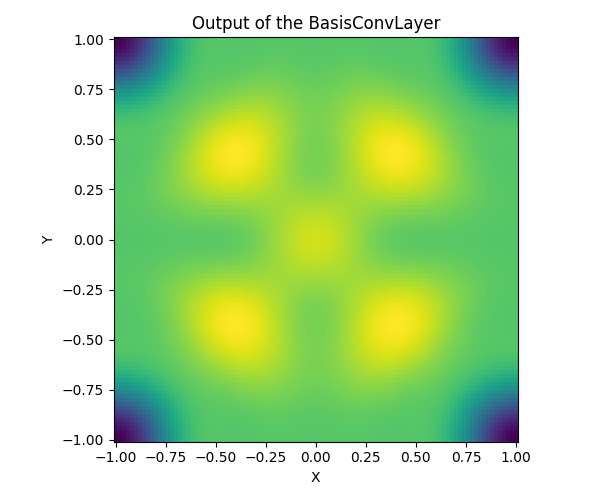

In [24]:
fig, axis = plt.subplots(1, 1, figsize=(6, 5), squeeze = False)

axis[0,0].pcolormesh(X.cpu().numpy(), Y.cpu().numpy(), out[:,0].detach().cpu().numpy().reshape(X.shape), shading='auto', cmap='viridis')

axis[0,0].set_title('Output of the BasisConvLayer')
axis[0,0].set_xlabel('X')
axis[0,0].set_ylabel('Y')
axis[0,0].set_aspect('equal')

fig.tight_layout()